# 0. Importar Librerías

In [7]:
import pandas as pd
import datetime
import requests
from pandas import json_normalize

# 1. Categorías
Explorar el Endpoint de Categorías

## 1.1 Conocer los tipos de Categorías

In [154]:
def fetch_categories(site='MLA'):
    url = f"https://api.mercadolibre.com/sites/{site}/categories"
    response = requests.get(url)
    return response.json()

categories = fetch_categories()
categories

df_cat = json_normalize(categories) 
df_cat.to_csv('../data/categories_MLA.csv', index=False)
df_cat#.head(10)

,id,name
0,MLA5725,Accesorios para Vehículos
1,MLA1512,Agro
2,MLA1403,Alimentos y Bebidas
3,MLA1071,Animales y Mascotas
4,MLA1367,Antigüedades y Colecciones
5,MLA1368,"Arte, Librería y Mercería"
6,MLA1743,"Autos, Motos y Otros"
7,MLA1384,Bebés
8,MLA1246,Belleza y Cuidado Personal
9,MLA1039,Cámaras y Accesorios


# 1.2 TOP publicaciones x Categoría
Debido al gran volumen de información en la API del Market Place de MELI, el UC se va a realizar con el TOP de las categorías más populares. Para ello, se selecciona la variable "Cantidad de Publicaciones" como el parámetro de Ranking, ya que la variable "Sold_quantity" no se encuentra accesible públicamente

In [15]:
import pandas as pd
import requests

def get_category_item_count(category_id, year, month):
    url = "https://api.mercadolibre.com/sites/MLA/search"
    start_date = f"{year}-{month:02d}-01T00:00:00.000-00:00"
    end_date = f"{year}-{month:02d}-31T23:59:59.999-00:00"
    params = {
        'category': category_id,
        'date_created': f"{start_date},{end_date}"
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        return data['paging']['total']
    else:
        print(f"Error al obtener la cantidad de ítems para la categoría {category_id}: {response.status_code}")
        return None

def get_all_categories_item_counts(year, month):
    url = "https://api.mercadolibre.com/sites/MLA/categories"
    response = requests.get(url)
    
    if response.status_code == 200:
        categories = response.json()
        category_counts = []
        for category in categories:
            category_id = category['id']
            category_name = category['name']
            item_count = get_category_item_count(category_id, year, month)
            if item_count is not None:
                category_counts.append((category_name, category_id, item_count))
        return category_counts
    else:
        print("Error al obtener las categorías:", response.status_code)
        return None

# Obtener el conteo de ítems para todas las categorías en el mes de mayo de 2024
year = 2024
month = 5
all_categories_item_counts = get_all_categories_item_counts(year, month)

# Crear DataFrame con la información de las categorías y su conteo de ítems
if all_categories_item_counts:
    df_categories = pd.DataFrame(all_categories_item_counts, columns=['Nombre', 'ID', 'Cantidad de Publicaciones'])

top_cat = df_categories.sort_values(by='Cantidad de Publicaciones', ascending=False).head(10)
list_top_cat = top_cat['ID'].to_list()
print(list_top_cat)

top_cat

['MLA1430', 'MLA1276', 'MLA1168', 'MLA1500', 'MLA1132', 'MLA1648', 'MLA1459', 'MLA407134', 'MLA1000', 'MLA1246']


,Nombre,ID,Cantidad de Publicaciones
27,Ropa y Accesorios,MLA1430,2441680
14,Deportes y Fitness,MLA1276,1058941
26,"Música, Películas y Series",MLA1168,928288
13,Construcción,MLA1500,755952
24,Juegos y Juguetes,MLA1132,737154
11,Computación,MLA1648,637385
21,Inmuebles,MLA1459,569830
18,Herramientas,MLA407134,537854
16,"Electrónica, Audio y Video",MLA1000,504368
8,Belleza y Cuidado Personal,MLA1246,501086


# 2. Endpoints adicionales (Search, items, users)

## 2.1 Extracción Dinámica (Search)
Extracción de Datos x Fechas y Categorías. La API de MELI tiene el límite en 50 registros por consulta, iterando por las páginas con el parámetro offset es posible ampliar el límite a 1000 registros

Consideraciones:
* Api Endpoint: https://api.mercadolibre.com/sites/MLA/search
* Filtro por Categoría
* Filtro por fechas
* Ordenamiento por cantidad de unidades vendidas (sold_quantity_desc)


In [121]:
# f(x) para obtener resultados de búsqueda de una categoría específica en el MarketPLace de MELI ARG.

def fetch_search_results(category_id, site='MLA', limit=1100, day_ini = '2024-05-01T00:00:00Z', day_end='2024-05-02T00:00:00Z'):
    url = f"https://api.mercadolibre.com/sites/{site}/search"
    params = {
        'category': category_id,
        'since': day_ini.isoformat() + 'T00:00:00Z',#'2024-05-01T00:00:00Z',
        'until': day_end.isoformat() + 'T00:00:00Z',#'2024-05-07T23:59:59Z', tener en cuenta este formato de fecha para las consultas
        'limit': 50,  # Máximo permitido por solicitud
        'sort': 'sold_quantity_desc'  # Ordenar por cantidad vendida
    }
    all_results = []
    offset = 0

    while len(all_results) < limit:
        params['offset'] = offset
        response = requests.get(url, params=params)
        data = response.json()
        results = data.get('results', [])

        if not results:
            break

        all_results.extend(results)
        offset += len(results)

        # Evitar superar el límite especificado
        if len(all_results) >= limit:
            all_results = all_results[:limit]
            break

    return all_results



start_date = datetime.datetime(2024, 5, 1)
end_date = datetime.datetime(2024, 5, 31)

fechas = pd.date_range(start_date, end_date)

# Lista de categorías
#lista_categorias = df_cat['id'].tolist()
lista_categorias = list_top_cat

#list_top_cat
log_filename2 = 'search_results_cat_log.txt'

for category_id in lista_categorias:
    df_search_full = pd.DataFrame()

    print(category_id)
    for fecha in fechas:
        search_results = fetch_search_results(category_id, day_ini=fecha, day_end=fecha + datetime.timedelta(days=1))
        filtered_results = [item for item in search_results if "variations_data" not in item] # las variables de variations no aportan y por lo general están en NULL
        df_search_results = pd.json_normalize(filtered_results)
        df_search_full = pd.concat([df_search_full, df_search_results], ignore_index=True)
        #print(f"Daily Results fetched: {len(df_search_results)}")
        log_message2 = f"{datetime.datetime.now()} - Categoría: {category_id} | Día: {fecha} | Daily Results fetched: {len(df_search_results)}"
        print(log_message2)
        
        # Escribir el LOG
        with open(log_filename2, 'a') as log_file2:
            log_file2.write(log_message2+ '\n')
        

    # Exportar el CSV para cada categoría
    df_search_full.to_csv(f'search_results_cat_{category_id}.csv', index=False)
    print(f"Exportado: search_results_cat_{category_id}.csv")

MLA1368
2024-06-13 00:00:40.123810 - Categoría: MLA1368 | Día: 2024-05-01 00:00:00 | Daily Results fetched: 966
2024-06-13 00:00:52.045115 - Categoría: MLA1368 | Día: 2024-05-02 00:00:00 | Daily Results fetched: 966
2024-06-13 00:01:05.495613 - Categoría: MLA1368 | Día: 2024-05-03 00:00:00 | Daily Results fetched: 966
2024-06-13 00:01:17.283673 - Categoría: MLA1368 | Día: 2024-05-04 00:00:00 | Daily Results fetched: 966
2024-06-13 00:01:30.413079 - Categoría: MLA1368 | Día: 2024-05-05 00:00:00 | Daily Results fetched: 966
2024-06-13 00:01:42.656504 - Categoría: MLA1368 | Día: 2024-05-06 00:00:00 | Daily Results fetched: 966
2024-06-13 00:01:54.074320 - Categoría: MLA1368 | Día: 2024-05-07 00:00:00 | Daily Results fetched: 966
2024-06-13 00:02:06.215370 - Categoría: MLA1368 | Día: 2024-05-08 00:00:00 | Daily Results fetched: 966
2024-06-13 00:02:17.932570 - Categoría: MLA1368 | Día: 2024-05-09 00:00:00 | Daily Results fetched: 966
2024-06-13 00:02:30.549664 - Categoría: MLA1368 | Día: 2

2024-06-13 00:22:28,587 - INFO     - Executing shutdown due to inactivity...


2024-06-13 00:22:31.729491 - Categoría: MLA1367 | Día: 2024-05-24 00:00:00 | Daily Results fetched: 675


2024-06-13 00:22:32,676 - INFO     - Executing shutdown...
2024-06-13 00:22:32,684 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


2024-06-13 00:22:40.542622 - Categoría: MLA1367 | Día: 2024-05-25 00:00:00 | Daily Results fetched: 675
2024-06-13 00:22:48.968838 - Categoría: MLA1367 | Día: 2024-05-26 00:00:00 | Daily Results fetched: 675
2024-06-13 00:22:58.549675 - Categoría: MLA1367 | Día: 2024-05-27 00:00:00 | Daily Results fetched: 675
2024-06-13 00:23:08.160770 - Categoría: MLA1367 | Día: 2024-05-28 00:00:00 | Daily Results fetched: 675
2024-06-13 00:23:17.260508 - Categoría: MLA1367 | Día: 2024-05-29 00:00:00 | Daily Results fetched: 675
2024-06-13 00:23:26.761315 - Categoría: MLA1367 | Día: 2024-05-30 00:00:00 | Daily Results fetched: 675
2024-06-13 00:23:36.248127 - Categoría: MLA1367 | Día: 2024-05-31 00:00:00 | Daily Results fetched: 675
Exportado: search_results_cat_MLA1367.csv
MLA3937
2024-06-13 00:23:51.841273 - Categoría: MLA3937 | Día: 2024-05-01 00:00:00 | Daily Results fetched: 784
2024-06-13 00:24:02.256608 - Categoría: MLA3937 | Día: 2024-05-02 00:00:00 | Daily Results fetched: 784
2024-06-13 00:

## 2.2 Extracción dinámica + seller_data + dates_data
Para cada registro del API Search, se complementa información de valor adicional con los endpoint de users (seller_data) e items (dates_data)

Consideraciones:
* Api Endpoint Search: https://api.mercadolibre.com/sites/MLA/search
* Api Endpoint Users: https://api.mercadolibre.com/users/{seller_id}  ||  Fields: [level_id, power_seller_status, # transactions]
* Api Endpoint Items: https://api.mercadolibre.com/items/{item_id}  ||  Fields: [last_updated, date_created]
* Filtro por Categoría
* Filtro por fechas
* Ordenamiento por cantidad de unidades vendidas (sold_quantity_desc)

In [5]:
def fetch_search_results(category_id, site='MLA', limit=1100, day_ini='2024-05-01T00:00:00Z', day_end='2024-05-02T00:00:00Z'):
    url = f"https://api.mercadolibre.com/sites/{site}/search"
    params = {
        'category': category_id,
        'since': day_ini,
        'until': day_end,
        'limit': 50,  # Máximo permitido por solicitud
        'sort': 'sold_quantity_desc'  # Ordenar por cantidad vendida
    }
    all_results = []
    offset = 0

    while len(all_results) < limit:
        params['offset'] = offset
        response = requests.get(url, params=params)
        data = response.json()
        results = data.get('results', [])

        if not results:
            break

        all_results.extend(results)
        offset += len(results)

        # Evitar superar el límite especificado
        if len(all_results) >= limit:
            all_results = all_results[:limit]
            break

    return all_results

def fetch_seller_info(seller_id):
    url = f"https://api.mercadolibre.com/users/{seller_id}"
    response = requests.get(url)
    seller_data = response.json()

    # SELLER info
    seller_info = {
        'seller_reputation': {
            'level_id': seller_data['seller_reputation'].get('level_id'),
            'power_seller_status': seller_data['seller_reputation'].get('power_seller_status'),
            'transactions': {
                'period': seller_data['seller_reputation']['transactions'].get('period'),
                'total': seller_data['seller_reputation']['transactions'].get('total')
            }
        }
    }
    return seller_info

def fetch_item_info(item_id):
    url = f"https://api.mercadolibre.com/items/{item_id}"
    response = requests.get(url)
    item_data = response.json()

    # ITEM info
    item_info = {
        'last_updated': item_data.get('last_updated'),
        'date_created': item_data.get('date_created')
    }
    return item_info

start_date = datetime.datetime(2024, 5, 1)
end_date = datetime.datetime(2024, 5, 5)
fechas = pd.date_range(start_date, end_date)
#lista_categorias = df_cat['id'].tolist()
lista_categorias = list_top_cat
#lista_categorias = ['MLA1430']

log_filename = 'search_results_log.txt'


for category_id in lista_categorias:
    df_search_full = pd.DataFrame()

    print(category_id)
    for fecha in fechas:
        search_results = fetch_search_results(category_id, day_ini=fecha.isoformat() + 'T00:00:00Z', day_end=(fecha + datetime.timedelta(days=1)).isoformat() + 'T00:00:00Z')
        filtered_results = [item for item in search_results if "variations_data" not in item]

        for item in filtered_results:
            seller_info = fetch_seller_info(item['seller']['id'])
            item_info = fetch_item_info(item['id'])
            
            item['seller_reputation'] = seller_info['seller_reputation']
            item['last_updated'] = item_info['last_updated']
            item['date_created'] = item_info['date_created']

        df_search_results = pd.json_normalize(filtered_results)
        df_search_full = pd.concat([df_search_full, df_search_results], ignore_index=True)
        #print(f"Día: {fecha} | Daily Results fetched: {len(df_search_results)}")
        log_message = f"{datetime.datetime.now()} - Categoría: {category_id} | Día: {fecha} | Daily Results fetched: {len(df_search_results)}"
        print(log_message)
        
        # Escribir el LOG
        with open(log_filename, 'a') as log_file:
            log_file.write(log_message + '\n')
        
    # Exportar el CSV para cada categoría
    df_search_full.to_csv(f'../data/api_data/api_data_full_4_{category_id}.csv', index=False)
    print(f"Exportado: api_data_full_4_{category_id}.csv")

MLA407134
2024-06-12 18:13:04.120517 - Categoría: MLA407134 | Día: 2024-05-01 00:00:00 | Daily Results fetched: 997
2024-06-12 18:18:27.613448 - Categoría: MLA407134 | Día: 2024-05-02 00:00:00 | Daily Results fetched: 996
2024-06-12 18:23:55.279053 - Categoría: MLA407134 | Día: 2024-05-03 00:00:00 | Daily Results fetched: 995
2024-06-12 18:29:27.905650 - Categoría: MLA407134 | Día: 2024-05-04 00:00:00 | Daily Results fetched: 997
Exportado: api_data_full_4_MLA407134.csv


# 3. Consolidar información

# 3.1 Concat Info
Concatenar la información de cada categoría en 1 sólo Dataframe

In [125]:
import os
import pandas as pd


ruta_directorio = '../data/api_data'


dfs = []


for archivo in os.listdir(ruta_directorio):
    if archivo.endswith('.csv'):
        categoria_code = archivo.split('_')[-1].replace('.csv', '')
        
        df = pd.read_csv(os.path.join(ruta_directorio, archivo))
        
        df['CATEGORIA_CODE'] = categoria_code
        
        dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

print(df_final)


                  id                                              title  \
0      MLA1425909273  Auriculares Bluetooth In-ear Gamer F9-5 Negro ...   
1      MLA1427905463      Auriculares Inalámbricos Jbl Tune 520bt Negro   
2      MLA1801816572  Auriculares In-ear Inalámbricos Xiaomi Redmi B...   
3      MLA1508684532  Parlante Philco Djp11p Portátil Con Bluetooth ...   
4      MLA1753715954  Pila Aa Energizer Max E91 Cilíndrica - Pack De...   
...              ...                                                ...   
77779  MLA1622989758   Mouse Pad Kolke Ked-149 Con Apoya Muñeca - Negro   
77780  MLA1349057588   Range Extender Tp-link Tl-wa850re V6 Blanco 220v   
77781  MLA1379341421                 Resma Boreal A4 70 Gr Color Blanco   
77782  MLA1431640311  Impresora Simple Función Pantum P2509w Wifi Bl...   
77783  MLA1435045028  Joystick Inalámbrico Dualsense Ps5 Original Co...   

      condition                  thumbnail_id catalog_product_id  \
0           new  938092-MLA4548

# 3.2 Load to DataBase

In [126]:
import pandas as pd 
from sqlalchemy import create_engine
import mysql.connector

try:
    mydb = mysql.connector.connect(
        host="localhost",
        user="root",
        password="123456"
    )
    print("Conexión OK")
    cursor = mydb.cursor()
    cursor.execute("create database if not exists meli_db")
    mydb.commit()
    print("DB creada OK")
    cursor.execute("use meli_db")

except mysql.connector.Error as err:
    print("Error:", err)

hostname= "localhost"
database= "meli_db"
username= "root"
password= "123456"

engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=database, user=username, pw=password))

df_final.to_sql('api_data', engine, if_exists='replace', index=False)

Conexión OK
DB creada OK


77784

In [127]:
df_final.columns

Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'use_thumbnail_id', 'accepts_mercadopago',
       'stop_time', 'attributes', 'winner_item_id', 'catalog_listing',
       'discounts', 'promotions', 'inventory_id', 'last_updated',
       'date_created', 'shipping.store_pick_up', 'shipping.free_shipping',
       'shipping.logistic_type', 'shipping.mode', 'shipping.tags',
       'shipping.benefits', 'shipping.promise', 'shipping.shipping_score',
       'seller.id', 'seller.nickname', 'installments.quantity',
       'installments.amount', 'installments.rate', 'installments.currency_id',
       'differential_pricing.id', 'seller_reputation.level_id',
       'seller_reputation.power_seller_status',
       'seller_reputation.transa

## 3.3 Sólo Data API Search May

In [138]:
import os
import pandas as pd


ruta_directorio = '../data/api_data_search'


dfs_SEARCH = []


for archivo in os.listdir(ruta_directorio):
    if archivo.endswith('.csv'):
        categoria_code = archivo.split('_')[-1].replace('.csv', '')
        
        df = pd.read_csv(os.path.join(ruta_directorio, archivo))
        
        df['CATEGORIA_CODE'] = categoria_code
        
        dfs_SEARCH.append(df)

df_final_SEARCH = pd.concat(dfs_SEARCH, ignore_index=True)

df_final_SEARCH.to_sql('api_data_search', engine, if_exists='replace', index=False)

df_final_SEARCH.head(3)

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,location.longitude,seller_contact.contact,seller_contact.other_info,seller_contact.webpage,seller_contact.area_code,seller_contact.phone,seller_contact.area_code2,seller_contact.phone2,seller_contact.email,variation_filters
0,MLA1425909273,Auriculares Bluetooth In-ear Gamer F9-5 Negro ...,new,938092-MLA45480677826_042021,MLA16224063,gold_pro,https://www.mercadolibre.com.ar/auriculares-bl...,buy_it_now,MLA,MLA3697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLA1427905463,Auriculares Inalámbricos Jbl Tune 520bt Negro,new,986177-MLU73187129209_122023,MLA23997257,gold_pro,https://www.mercadolibre.com.ar/auriculares-in...,buy_it_now,MLA,MLA3697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MLA1801816572,Auriculares In-ear Inalámbricos Xiaomi Redmi B...,new,677855-MLA71570451917_092023,MLA22609606,gold_special,https://www.mercadolibre.com.ar/auriculares-in...,buy_it_now,MLA,MLA3697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Feature Selection


## 4.1. SQL (Base de Datos)
Análisis de Faltantes y significado de las columnas

## 4.2 Dtale (EDA Framework)
Análisis de Distribuciones y Correlaciones

In [ ]:
import dtale
d = dtale.show(df_final)

2024-06-12 22:58:35,460 - ERROR    - 192.168.0.15 - - [12/Jun/2024 22:58:35] code 400, message Bad request version ('Ó«§')
2024-06-12 22:58:35,466 - ERROR    - 192.168.0.15 - - [12/Jun/2024 22:58:35] code 400, message Bad request version ('\x8aø\x94j]?GE')
2024-06-12 23:03:18,949 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,954 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,957 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,959 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,960 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,961 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,963 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,966 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:03:18,968 - WARNING  - findfont: Font family 'Heiti TC' not found.
2024-06-12 23:

In [93]:
import dtale
d1 = dtale.show(df_clean)

## 4.3 RF Feature Importance |-| Descuentos y Precios

In [128]:
#[DATA PREP]
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# DROP IRRELEVANT FEATS. AND HIGH MISSING VALUES
df_clean = df_final.drop(columns=['id', 'title','catalog_product_id', 'thumbnail_id', 'currency_id', 'site_id', 'domain_id', 'winner_item_id', 'inventory_id',  'use_thumbnail_id', 'official_store_id',
                                    'stop_time', 'permalink',   'official_store_name', 'thumbnail',
                                    'discounts', 'promotions',  'attributes', 'shipping.tags', 
                                    'shipping.store_pick_up', 'shipping.mode',
                                    'shipping.benefits', 'shipping.promise', 'shipping.shipping_score',
                                    'seller.id', 'seller.nickname', 'installments.currency_id',
                                    'installments', # tienen mayor relación con la forma de pago que con el producto en sí. En Feat_importance destacaban con respecto a precio, pero en realidad no son útiles para el modelo pred.
                                    'differential_pricing.id',
                                    'shipping.logistic_type', 'order_backend' ,'sale_price', 'category_id',
                                    'location.address_line', 'location.zip_code',
                                    'location.subneighborhood', 'location.neighborhood.id',
                                    'location.neighborhood.name', 'location.city.id', 'location.city.name',
                                    'location.state.id', 'location.state.name', 'location.country.id',
                                    'location.country.name', 'location.latitude', 'location.longitude',
                                    'seller_contact.contact', 'seller_contact.other_info',
                                    'seller_contact.webpage', 'seller_contact.area_code',
                                    'seller_contact.phone', 'seller_contact.area_code2',
                                    'seller_contact.phone2', 'seller_contact.email', 'seller_reputation.transactions.period',
                                    'variation_filters',
                                    'last_updated', 'date_created',
                                    'installments.quantity', 'installments.amount', 'installments.rate',
                                    'CATEGORIA_CODE'
                                    #'catalog_listing', 
                                    ])

# Missing values
print('Before DROP NAN price: ', len(df_clean))
df_clean = df_clean.dropna(subset=['price']) 
print('After DROP NAN price: ', len(df_clean))
# FLAG de Descuentos
df_clean['has_discount'] = ~df_clean['original_price'].isna()


# NAN original price -> Price
df_clean['original_price'] = df_clean['original_price'].fillna(df_clean['price'])

# NAN level_id  -> WHITE
df_clean['seller_reputation.level_id'] = df_clean['seller_reputation.level_id'].fillna('0_BLANK')
df_clean['seller_reputation.power_seller_status'] = df_clean['seller_reputation.power_seller_status'].fillna('BLANK')


# discount_percentage
df_clean['discount_percentage'] = ((df_clean['original_price'] - df_clean['price']) / df_clean['original_price']) * 100

# CAT VARS (Frequency encoding)
categorical_cols = ['condition', 'buying_mode', 'listing_type_id', 'catalog_listing',  'seller_reputation.level_id', 'seller_reputation.power_seller_status']
for col in categorical_cols:
    freq_encoding = df_clean[col].value_counts() / len(df_clean)
    df_clean[col + '_freq'] = df_clean[col].map(freq_encoding)

# Drop original CAT VARS
df_clean = df_clean.drop(columns=categorical_cols)
df_clean

Before DROP NAN price:  77784
After DROP NAN price:  77784


,price,original_price,available_quantity,accepts_mercadopago,shipping.free_shipping,seller_reputation.transactions.total,has_discount,discount_percentage,condition_freq,buying_mode_freq,listing_type_id_freq,catalog_listing_freq,seller_reputation.level_id_freq,seller_reputation.power_seller_status_freq
0,7599.00,9999.0,500,True,False,175126,True,24.002400,0.962267,0.910007,0.199630,0.86978,0.887779,0.770313
1,68999.00,68999.0,1,True,True,81051,False,0.000000,0.962267,0.910007,0.199630,0.86978,0.887779,0.770313
2,33894.00,33894.0,50,True,True,10585,False,0.000000,0.962267,0.910007,0.710377,0.86978,0.887779,0.770313
3,59999.00,78999.0,200,True,True,831576,True,24.050937,0.962267,0.910007,0.199630,0.86978,0.887779,0.770313
4,4200.00,4200.0,150,True,False,37007,False,0.000000,0.962267,0.910007,0.710377,0.86978,0.887779,0.770313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77779,4999.00,4999.0,50,True,False,39244,False,0.000000,0.962267,0.910007,0.710377,0.86978,0.887779,0.770313
77780,28217.18,32599.0,1,True,True,54609,True,13.441578,0.962267,0.910007,0.710377,0.86978,0.887779,0.770313
77781,7299.00,7299.0,500,True,False,103287,False,0.000000,0.962267,0.910007,0.710377,0.86978,0.887779,0.770313
77782,161999.00,161999.0,1,True,True,80982,False,0.000000,0.962267,0.910007,0.199630,0.86978,0.887779,0.770313


In [129]:
df_clean.columns

Index(['price', 'original_price', 'available_quantity', 'accepts_mercadopago',
       'shipping.free_shipping', 'seller_reputation.transactions.total',
       'has_discount', 'discount_percentage', 'condition_freq',
       'buying_mode_freq', 'listing_type_id_freq', 'catalog_listing_freq',
       'seller_reputation.level_id_freq',
       'seller_reputation.power_seller_status_freq'],
      dtype='object')

In [130]:
from sklearn.ensemble import RandomForestRegressor

# [SELECT RELEVANT FEATS]
features = df_clean.drop(columns=['price', 'original_price', 'discount_percentage', 'has_discount'])
target_price = df_clean['price']
target_discount = df_clean['discount_percentage']

# Split data into training and testing sets
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(features, target_price, test_size=0.2, random_state=42)
X_train_discount, X_test_discount, y_train_discount, y_test_discount = train_test_split(features, target_discount, test_size=0.2, random_state=42)

# Train RF
model_price = RandomForestRegressor(n_estimators=100, random_state=42)
model_price.fit(X_train_price, y_train_price)

model_discount = RandomForestRegressor(n_estimators=100, random_state=42)
model_discount.fit(X_train_discount, y_train_discount)

RandomForestRegressor(random_state=42)

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Make predictions on the test set
y_pred_price = model_price.predict(X_test_price)
y_pred_discount = model_discount.predict(X_test_discount)

# Calculate accuracy metrics for price prediction
mae_price = mean_absolute_error(y_test_price, y_pred_price)
mse_price = mean_squared_error(y_test_price, y_pred_price)
r2_price = r2_score(y_test_price, y_pred_price)

# Calculate accuracy metrics for discount percentage prediction
mae_discount = mean_absolute_error(y_test_discount, y_pred_discount)
mse_discount = mean_squared_error(y_test_discount, y_pred_discount)
r2_discount = r2_score(y_test_discount, y_pred_discount)

print("Price Prediction Metrics:")
print(f"Mean Absolute Error (MAE): {mae_price}")
print(f"Mean Squared Error (MSE): {mse_price}")
print(f"R-squared (R²): {r2_price}")

print("\nDiscount Percentage Prediction Metrics:")
print(f"Mean Absolute Error (MAE): {mae_discount}")
print(f"Mean Squared Error (MSE): {mse_discount}")
print(f"R-squared (R²): {r2_discount}")

Price Prediction Metrics:
Mean Absolute Error (MAE): 57916.58252394446
Mean Squared Error (MSE): 2359607691482.412
R-squared (R²): 0.04109270631469164

Discount Percentage Prediction Metrics:
Mean Absolute Error (MAE): 1.5321307873497956
Mean Squared Error (MSE): 24.325773680959408
R-squared (R²): 0.8125011387647082


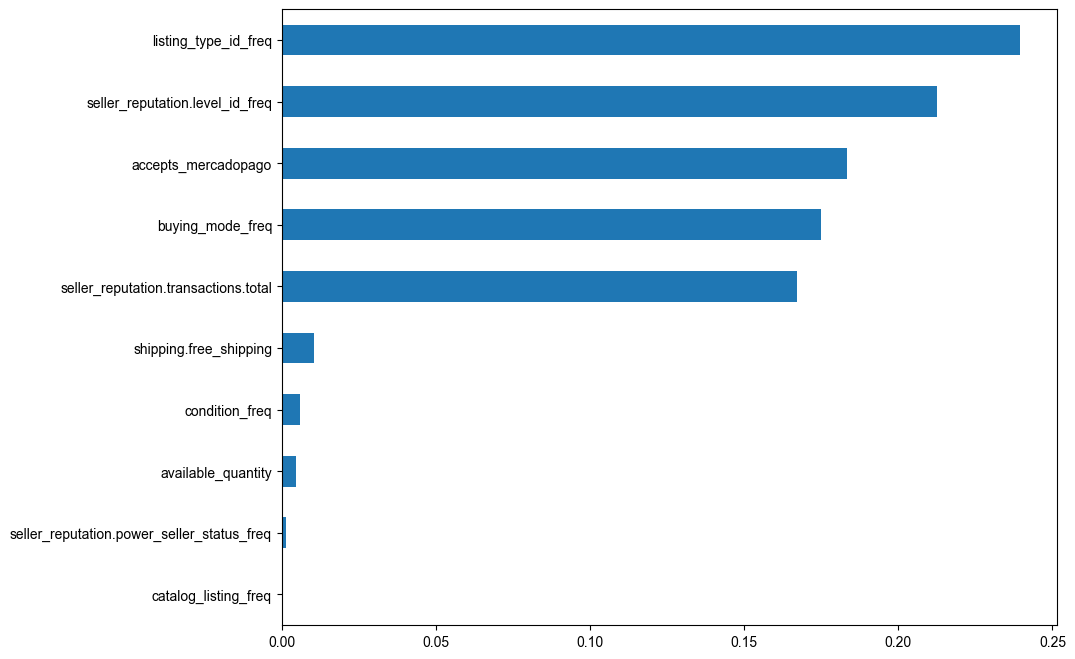

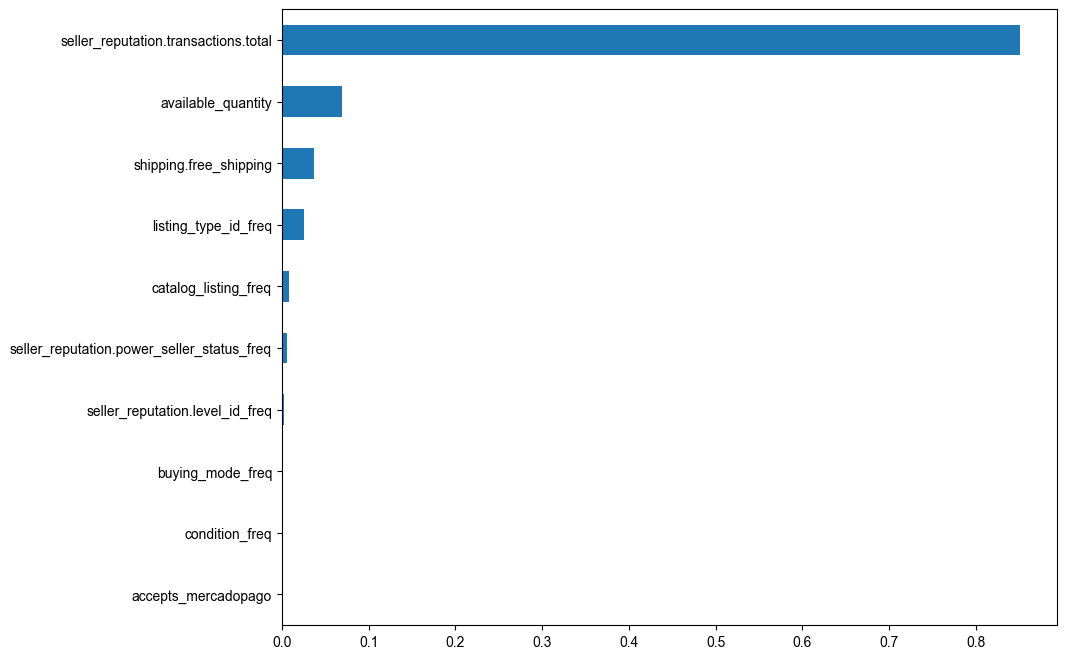

In [132]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings

warnings.filterwarnings('ignore')

mpl.rcParams['font.family'] = 'Arial'

# Get feature importances
importances_price = model_price.feature_importances_
importances_discount = model_discount.feature_importances_

# Convert to pandas series for easier handling
feat_importances_price = pd.Series(importances_price, index=features.columns)
feat_importances_discount = pd.Series(importances_discount, index=features.columns)

# Plot feature importances
def plot_feature_importances(importances, title):
    importances.sort_values().plot(kind='barh', figsize=(10, 8))
    #plt.title(title)
    plt.show()

plot_feature_importances(feat_importances_price, "Feature Importances for Price Prediction");
plot_feature_importances(feat_importances_discount, "Feature Importances for Discount Prediction");

In [133]:
print('PRICE')
print(feat_importances_price.sort_values(ascending=False))

PRICE
listing_type_id_freq                          0.239456
seller_reputation.level_id_freq               0.212643
accepts_mercadopago                           0.183497
buying_mode_freq                              0.174967
seller_reputation.transactions.total          0.167042
shipping.free_shipping                        0.010560
condition_freq                                0.005981
available_quantity                            0.004507
seller_reputation.power_seller_status_freq    0.001300
catalog_listing_freq                          0.000047
dtype: float64


In [134]:
print('DISCOUNTS')
print(feat_importances_discount.sort_values(ascending=False))

DISCOUNTS
seller_reputation.transactions.total          0.850656
available_quantity                            0.069722
shipping.free_shipping                        0.037414
listing_type_id_freq                          0.025871
catalog_listing_freq                          0.007819
seller_reputation.power_seller_status_freq    0.005610
seller_reputation.level_id_freq               0.002908
accepts_mercadopago                           0.000000
condition_freq                                0.000000
buying_mode_freq                              0.000000
dtype: float64


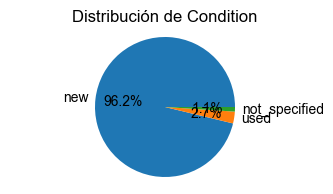

In [135]:
condition_counts = df_final['condition'].value_counts()

plt.figure(figsize=(4, 2))
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%')
plt.title('Distribución de Condition')
plt.axis('equal') 
plt.show()

La mayoría de items en el MArketplace son nuevos, por ello con el tipo de codif elegido para la variable Condition la variabilidad es muy baja y por lo tanto su impacto también es bajo con relación a los targets (descuento y precio). Sin embargo se decide conservarla, porque es posible que aporte en el modelamiento predictivo del precio.

# 5. Conclusión
Después de Explorar y analizar las múltiples variables que tienen los endpoints de las APIs del Marketplace de MELI, las columnas del DATASET base para el análisis de descuentos y precios son las siguientes:

* ID
* TITLE
* PRICE
* ORIGINAL_PRICE
* AVAILABLE_QUANTITY
* BUYING_MODE
* LISTING_TYPE_ID
* ACCEPTS_MERCADOPAGO
* CATEGORY_ID
* condition
* shipping.free_shipping
* catalog_listing
* last_updated
* date_created
* seller.id
* seller.nickname
* seller_reputation.level_id
* seller_reputation.power_seller_status
* seller_reputation.transactions.total

Nota: esta la información BASE sobre la cuál se desarrollará el análisis de descuentos ypredicción de precios. Cada UC puede tener particualridades y ecxlusiones de las mismas.

In [ ]:
''' CREACIIÓN TABLA CON LAS COLUMNAS BASE

create table API_DATA_SELECTED_COLS AS
select distinct ID, TITLE, 
PRICE,
ORIGINAL_PRICE,
AVAILABLE_QUANTITY,
BUYING_MODE,
LISTING_TYPE_ID,
ACCEPTS_MERCADOPAGO,
CATEGORY_ID,
`condition`,
`shipping.free_shipping`,
catalog_listing,
last_updated, 
date_created,
`seller.id`,
`seller.nickname`,
`seller_reputation.level_id`,
`seller_reputation.power_seller_status`,
`seller_reputation.transactions.total`
from api_data ad;'''

'''create table API_DATA_SEARCH_SELECTED_COLS AS
select distinct ID, TITLE, 
PRICE,
ORIGINAL_PRICE,
AVAILABLE_QUANTITY,
BUYING_MODE,
LISTING_TYPE_ID,
ACCEPTS_MERCADOPAGO,
CATEGORIA_CODE,
`condition`,
`shipping.free_shipping`,
catalog_listing
from api_data_search ad; -> Exported  912.102 rows'''

# 6. Exportar Dataset

# 6.1 Dataset base

In [136]:
query = "SELECT * FROM API_DATA_SELECTED_COLS"
df_loaded = pd.read_sql(query, con=engine)

df_loaded.to_csv('../data/dataset_base.csv', index=False)

print(df_loaded.head())

mydb.close()

              ID                                              TITLE    PRICE  \
0  MLA1425909273  Auriculares Bluetooth In-ear Gamer F9-5 Negro ...   7599.0   
1  MLA1427905463      Auriculares Inalámbricos Jbl Tune 520bt Negro  68999.0   
2  MLA1801816572  Auriculares In-ear Inalámbricos Xiaomi Redmi B...  33894.0   
3  MLA1508684532  Parlante Philco Djp11p Portátil Con Bluetooth ...  59999.0   
4  MLA1753715954  Pila Aa Energizer Max E91 Cilíndrica - Pack De...   4200.0   

   ORIGINAL_PRICE  AVAILABLE_QUANTITY BUYING_MODE LISTING_TYPE_ID  \
0          9999.0                 500  buy_it_now        gold_pro   
1             NaN                   1  buy_it_now        gold_pro   
2             NaN                  50  buy_it_now    gold_special   
3         78999.0                 200  buy_it_now        gold_pro   
4             NaN                 150  buy_it_now    gold_special   

   ACCEPTS_MERCADOPAGO CATEGORIA_CODE condition  shipping.free_shipping  \
0                    1       

## 6.2 Dataset full Mayo

In [144]:
df_final_SEARCH.columns

Index(['id', 'title', 'condition', 'thumbnail_id', 'catalog_product_id',
       'listing_type_id', 'permalink', 'buying_mode', 'site_id', 'category_id',
       'domain_id', 'thumbnail', 'currency_id', 'order_backend', 'price',
       'original_price', 'sale_price', 'available_quantity',
       'official_store_id', 'use_thumbnail_id', 'accepts_mercadopago',
       'stop_time', 'attributes', 'winner_item_id', 'catalog_listing',
       'discounts', 'promotions', 'inventory_id', 'shipping.store_pick_up',
       'shipping.free_shipping', 'shipping.logistic_type', 'shipping.mode',
       'shipping.tags', 'shipping.benefits', 'shipping.promise',
       'shipping.shipping_score', 'seller.id', 'seller.nickname',
       'installments.quantity', 'installments.amount', 'installments.rate',
       'installments.currency_id', 'differential_pricing.id',
       'official_store_name', 'installments', 'CATEGORIA_CODE',
       'location.address_line', 'location.zip_code',
       'location.subneighborhood

In [148]:
df_final_SEARCH_use_cols = df_final_SEARCH[['id', 'title', 'condition', 'price', 'original_price', 'available_quantity', 'buying_mode',
                                   'listing_type_id', 'accepts_mercadopago','CATEGORIA_CODE', 'shipping.free_shipping', 'catalog_listing']]
df_final_SEARCH_use_cols.to_csv('../data/dataset_search.csv', index=False)

In [152]:
df_final_SEARCH_use_cols[['title', 'price', 'original_price', 'CATEGORIA_CODE']].to_csv('../data/dataset_llm.csv', index=False)